# 06 Trees Homework

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../datasets/car_fuel_efficiency.csv")
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


## Clean the data

- Fill missing values with zeros.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.


In [3]:
df.isna().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [4]:
# fill with zeros
df = df.fillna(0)
df.isna().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [5]:
# create a train, val, and test dataset
from sklearn.model_selection import train_test_split

df_full_train, df_val = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_test = train_test_split(df_full_train, test_size=0.25,random_state=1)

In [6]:
# worked
df_val.shape == df_test.shape

True

In [7]:
# reset the indices
df_test = df_test.reset_index()
df_val = df_val.reset_index()
df_train = df_train.reset_index()

# get the response variables
y_test = df_test.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_train= df_train.fuel_efficiency_mpg.values

# remove the response
del df_test['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_train['fuel_efficiency_mpg']

In [8]:
# convert train, test, split into dictionaries

dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')
dict_test = df_test.to_dict(orient='records')

# convert into usuable training data
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)
X_test = dv.transform(dict_test)

## Question 1

Let's train a decision tree regressor to predict the fuel_efficiency_mpg variable.

Train a model with max_depth=1.
Which feature is used for splitting the data?

- 'vehicle_weight'
- 'model_year'
- 'origin'
- 'fuel_type'

Q1: __`Vehicle weight`__

In [9]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [12]:
# visualize the tree
from sklearn.tree import export_text

export_text(dt, feature_names=list(dv.get_feature_names_out()))

'|--- vehicle_weight <= 3022.11\n|   |--- value: [16.88]\n|--- vehicle_weight >  3022.11\n|   |--- value: [12.94]\n'

## Question 2
Train a random forest regressor with these parameters:

n_estimators=10
random_state=1
n_jobs=-1 (optional - to make training faster)
What's the RMSE of this model on the validation data?

__RMSE: 0.4534__

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

rf = RandomForestRegressor(n_estimators=10,
                           random_state=1,
                           n_jobs=-1)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

rf_rmse = root_mean_squared_error(y_true=y_val, y_pred=y_pred_rf)
round(rf_rmse, 4)

0.4534

## Question 3

Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.
Set random_state to 1.
Evaluate the model on the validation dataset.
After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.

10
25
80
200
If it doesn't stop improving, use the latest iteration number in your answer.

__Flatlines around 80, definitely no improvement at 200.__

In [18]:
rf_scores = []
for n in range(10, 201, 10):

    rf = RandomForestRegressor(n_estimators=n,
                           random_state=1,
                           n_jobs=-1)
    
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_val)

    rf_rmse = root_mean_squared_error(y_true=y_val, y_pred=y_pred_rf)
    res = (n, rf_rmse)
    rf_scores.append(res)

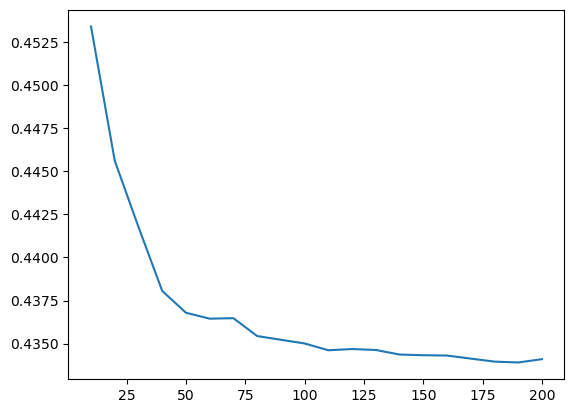

In [ ]:
rf_df = pd.DataFrame(rf_scores, columns=['n_estimators', 'rmse'])

plt.plot(rf_df.n_estimators, rf_df.rmse)
plt.show()

## Question 4
Let's select the best max_depth:

Try different values of max_depth: [10, 15, 20, 25]
For each of these values,
try different values of n_estimators from 10 till 200 (with step 10)
calculate the mean RMSE
Fix the random seed: random_state=1
What's the best max_depth, using the mean RMSE?

10
15
20
25

__The best max depth is 10__


In [21]:
rf_scores_est_dep = []
for d in range(10, 30, 5):
    for n in range(10, 201, 10):

        rf = RandomForestRegressor(n_estimators=n,
                            max_depth=d,
                            random_state=1,
                            n_jobs=-1)
        
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_val)

        rf_rmse = root_mean_squared_error(y_true=y_val, y_pred=y_pred_rf)
        res = (d, n, rf_rmse)
        rf_scores_est_dep.append(res)

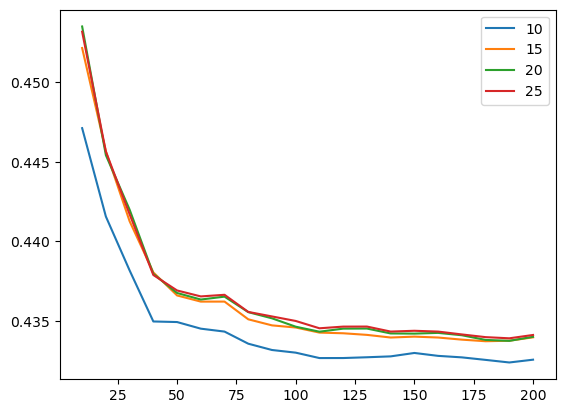

In [28]:
rf_df_est_dep = pd.DataFrame(rf_scores_est_dep, columns=['max_depth', 'n_estimators', 'rmse'])

for d in range(10, 30, 5):
    df_subset = rf_df_est_dep[rf_df_est_dep['max_depth'] == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'{d}')
    plt.legend()

plt.show()

## Question 5
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parameters:
n_estimators=10,
max_depth=20,
random_state=1,
n_jobs=-1 (optional)
Get the feature importance information from this model
What's the most important feature (among these 4)?

- vehicle_weight
- horsepower
- acceleration
- engine_displacement

Q5: __`Vehicle Weight`__

In [36]:

rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20,
                           random_state=1,
                           n_jobs=-1)

rf.fit(X_train, y_train)

feature_df = pd.DataFrame({
    'features': dv.get_feature_names_out(),
    'importance': rf.feature_importances_
})
feature_df

,features,importance
0,acceleration,0.010908
1,drivetrain=All-wheel drive,0.000266
2,drivetrain=Front-wheel drive,0.000296
3,engine_displacement,0.002856
4,fuel_type=Diesel,0.000267
5,fuel_type=Gasoline,0.000332
6,horsepower,0.015336
7,index,0.003564
8,model_year,0.002809
9,num_cylinders,0.001998


## Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

Q6: __Slightly better performance with eta=0.1, but almost identical__


In [45]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(dv.get_feature_names_out()))
dval = xgb.DMatrix(X_val, label=y_val, feature_names=list(dv.get_feature_names_out()))
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(dv.get_feature_names_out()))

In [46]:
watchlist = [(dtrain, 'train'), (dval, 'validation')]

In [53]:
xgb_params_01 = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [58]:
evals_result_eta01 = {}

model = xgb.train(params=xgb_params_01,  # params defined above
                  dtrain=dtrain, 
                  num_boost_round=100, # total number of iterations
                  verbose_eval=10, # prints the progress of training every 10 training rounds
                  evals=watchlist, # monitor the metric for training and validation
                  evals_result = evals_result_eta01)

[0]	train-rmse:1.81393	validation-rmse:1.86841
[10]	train-rmse:0.37063	validation-rmse:0.43093
[20]	train-rmse:0.33100	validation-rmse:0.42522
[30]	train-rmse:0.30853	validation-rmse:0.42657
[40]	train-rmse:0.28960	validation-rmse:0.43041
[50]	train-rmse:0.27289	validation-rmse:0.43310
[60]	train-rmse:0.25483	validation-rmse:0.43531
[70]	train-rmse:0.24077	validation-rmse:0.43795
[80]	train-rmse:0.22752	validation-rmse:0.43979
[90]	train-rmse:0.21316	validation-rmse:0.44092
[99]	train-rmse:0.20260	validation-rmse:0.44231


In [59]:
xgb_params_03 = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [60]:
evals_result_eta03 = {}

model = xgb.train(params=xgb_params_03,  # params defined above
                  dtrain=dtrain, 
                  num_boost_round=100, # total number of iterations
                  verbose_eval=10, # prints the progress of training every 10 training rounds
                  evals=watchlist, # monitor the metric for training and validation
                  evals_result = evals_result_eta03)

[0]	train-rmse:2.28944	validation-rmse:2.35353
[10]	train-rmse:0.91008	validation-rmse:0.94906
[20]	train-rmse:0.48973	validation-rmse:0.53410
[30]	train-rmse:0.38379	validation-rmse:0.44258
[40]	train-rmse:0.35265	validation-rmse:0.42365
[50]	train-rmse:0.33911	validation-rmse:0.41937
[60]	train-rmse:0.32793	validation-rmse:0.41888
[70]	train-rmse:0.31988	validation-rmse:0.41915
[80]	train-rmse:0.31340	validation-rmse:0.41934
[90]	train-rmse:0.30666	validation-rmse:0.42008
[99]	train-rmse:0.30256	validation-rmse:0.42038


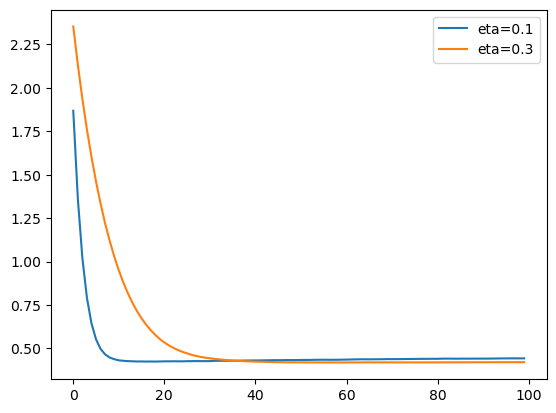

In [61]:
# graph the result
plt.plot(evals_result_eta01['validation']['rmse'], label='eta=0.1')
plt.plot(evals_result_eta03['validation']['rmse'], label='eta=0.3')
plt.legend()
plt.show()

